In [8]:
import random
import sys
import os
import types
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import random
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import PIL
from torch.autograd import Variable
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import cv2

from lime import lime_image
from skimage.segmentation import mark_boundaries

from models import Efficientnet


In [21]:
train_csv_path = '/home/tu-serbin/data/chexpert/v1.0/train.csv'
valid_csv_path = '/home/tu-serbin/data/chexpert/v1.0/valid.csv'
model_save_dir = '/home/tu-serbin/group/igloo/alex/saves/'
dir_path = '/home/tu-serbin/data/chexpert/v1.0/'
data_path = '/home/tu-serbin/data/'



## Data preparation

In [22]:
#function which drops lateral image records and irrelevant columns, replaces -1 with 0, corrects Path column

def dropper(df):
    d = df.copy()
    index = d[d["Frontal/Lateral"] == "Lateral"].index
    d.drop(index=index, axis=0, inplace=True)
    d = d.drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    #d = d.replace(-1.0,0)
    d.Path = d.Path.str.replace('CheXpert-','chexpert/')
    d = d.reset_index(drop=True)
    return d

In [23]:
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
dval = dropper(valid_csv)

train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
dtrain = dropper(train_csv)

# image paths Series
vpath = dval.Path#.str.replace('CheXpert-','chexpert/')
tpath = dtrain.Path#.str.replace('CheXpert-','chexpert/')

## Transforms

In [24]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

efnet_transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

In [25]:
# receives a binary vector and outputs 1d array with indexes of elements which are ones

def findings(z, beta=0.5):

    # assume z is a tensor 
    if type(z) != np.ndarray:
        y = z.squeeze().numpy()
        #print('shape',y.shape)
    else:
        y = z.copy().squeeze()
        #print(y)

    idx = np.argwhere(y > beta)

    if idx.ndim > 1:
        idx = idx.squeeze()

    if idx.ndim == 0:
        idx = np.expand_dims(idx,0)
        #print(type(idx),[idx])
    return idx

## Load model

In [26]:
efnet = Efficientnet()

#Load weights
#load2 = torch.load(model_save_dir+'epoch_3_score_0.88577.pth', map_location='cpu')
#efnet.load_state_dict(load2['state_dict'])
_ = efnet.eval()

Loaded pretrained weights for efficientnet-b5


In [27]:
# gradients for gradcam are stored here
stored_grads = torch.Tensor([])
stored_fpass = torch.Tensor([])

In [28]:
def bpass_hook(self, gin, gout):
    global stored_grads
    stored_grads = gout
    #stored_grads = torch.cat((stored_grads,gin),0)

In [29]:
def fpass_hook(self, ten_in, ten_out):
    global stored_fpass
    stored_fpass = ten_out

In [30]:
# register hooks
handle_b = efnet.net._conv_head.register_backward_hook(bpass_hook)
handle_f = efnet.net._conv_head.register_forward_hook(fpass_hook)

In [34]:
# get image and true labels
imid = np.random.randint(dtrain.shape[0])
print(imid)
path1 = data_path+dtrain.Path[imid]

image_orig = Image.open(path1).convert('RGB')
trim = efnet_transform(image_orig).unsqueeze(0)

true_labels_vec = dtrain.iloc[imid,1:].to_numpy().astype(int)
true_labels = np.argwhere(true_labels_vec==1).flatten()
true_labels_uncertain = np.argwhere((-1)*true_labels_vec==1).flatten()

100588


1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 4  6 11] ['Lung Lesion', 'Consolidation', 'Pleural Other']
Probabilities: [0.53 0.52 0.54]


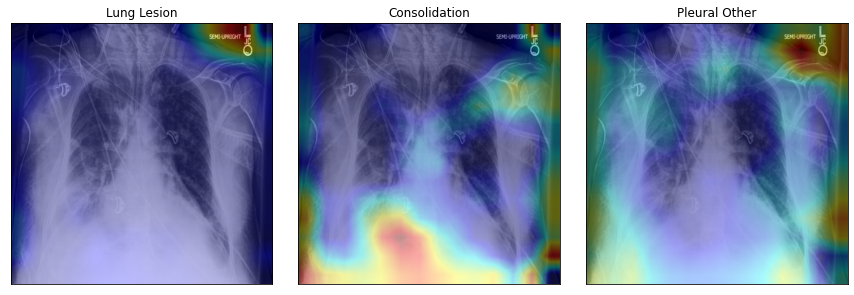

In [35]:
# run model
out = efnet(trim)
out_np = out.detach().numpy().squeeze()
pred_labels = findings(out_np)
pred_labels_p = np.round(out_np[pred_labels], 2)

# generate argument vectors for backward() function.
# generate as many as there are predicted classes with p>0.5 (implemented in function 'findings')

l = len(pred_labels)
args = []
for ii in pred_labels:
    backward_arg = torch.zeros(1,14)
    backward_arg[0,ii] = 1
    args.append(backward_arg)
# generate gradCAMs and plot them

hmap_list = []
cam_list = []

img_hmap = np.transpose(trim.squeeze().numpy(),(1,2,0))

arglen = len(args)
kwargs = dict(xticks=[],yticks=[])

fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
if arglen==1:
    ax = [ax]
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for k, a in enumerate(args):
    print('{}/{}'.format(k+1,arglen))
    out.backward(a, retain_graph=True)

    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for j in range(gradients.shape[1]):
        activations[:, j, :, :] *= pooled_gradients[j]

    heatmap = torch.sum(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    hmap_list.append(heatmap)
    
    #ax.flatten()[k].imshow(heatmap)
    

    hmap = heatmap.numpy()
    heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
    heatmap1 = np.uint8(-255 * heatmap1 + 255)
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    supim = heatmap1 * 0.002 + img_hmap
    supim = supim / supim.max()
    
    cam_list.append(supim)
    
    ax[k].imshow(supim)
    ax[k].set_title(dtrain.columns[1:][pred_labels[k]])

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('True labels:', true_labels, dtrain.columns[1:][true_labels].to_list())
print('Uncertainties:', true_labels_uncertain, dtrain.columns[1:][true_labels_uncertain].to_list())
print('Prediction:', pred_labels, dtrain.columns[1:][pred_labels].to_list())
print('Probabilities:', pred_labels_p)

100588


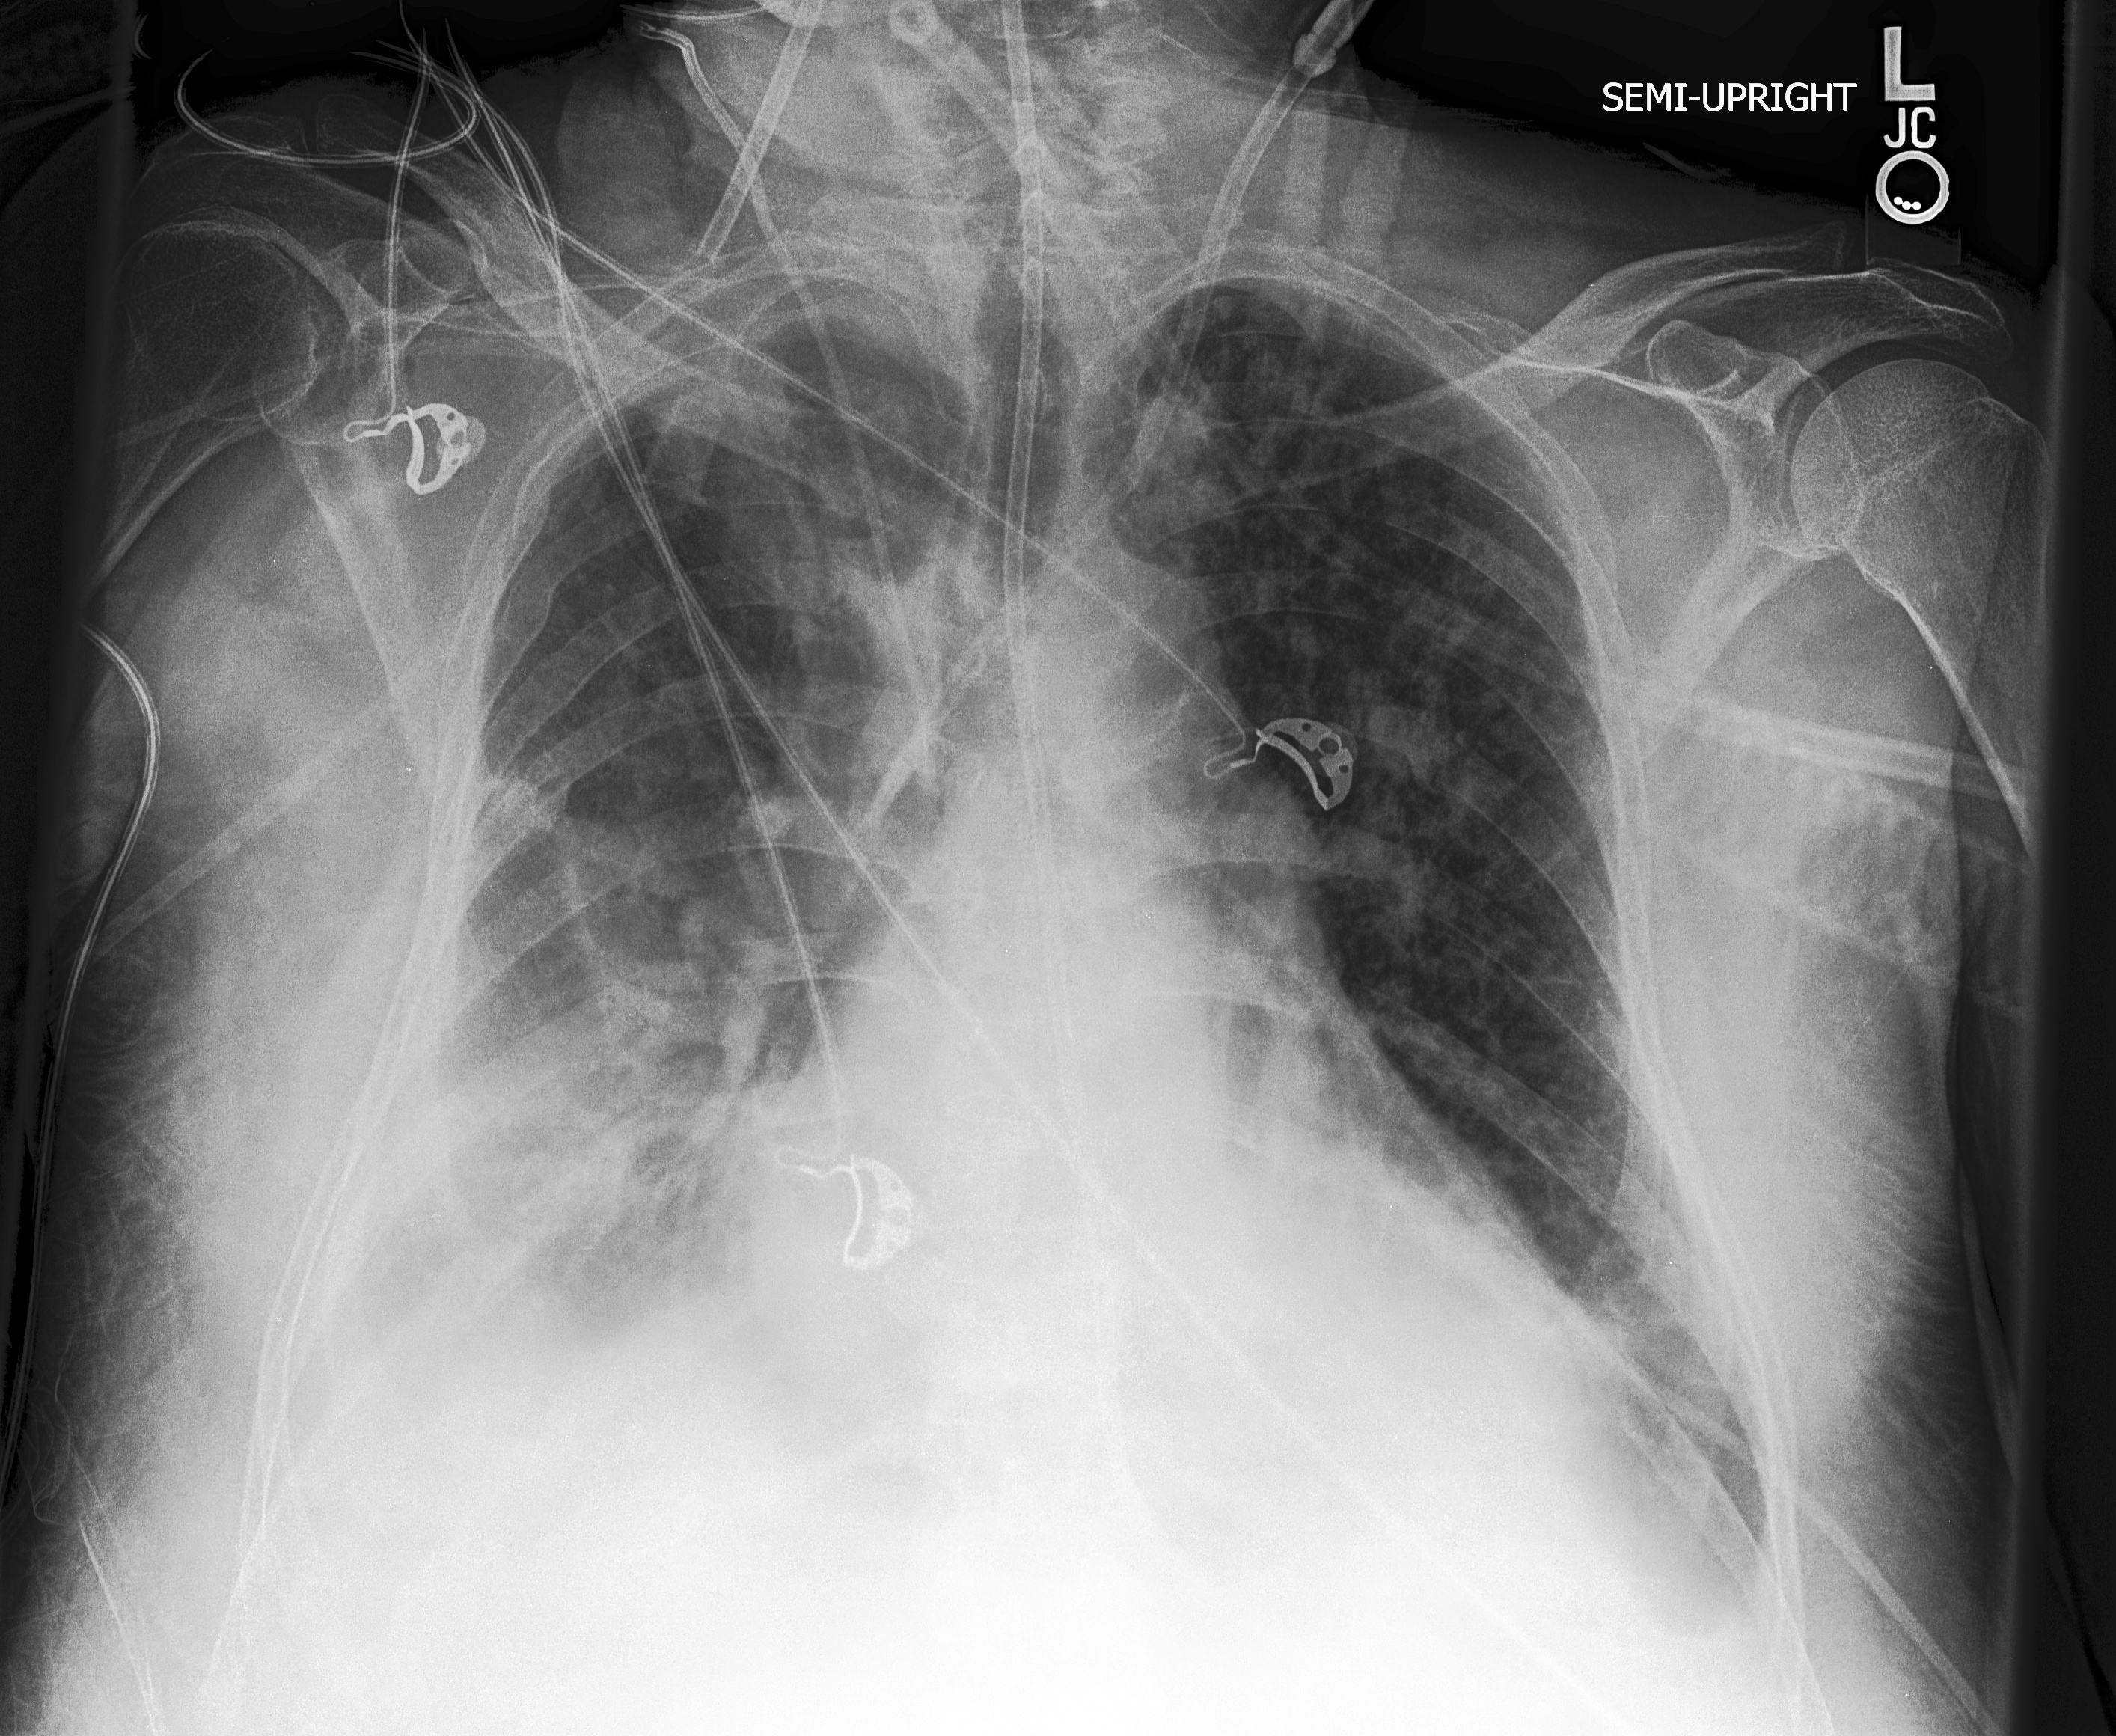

In [36]:
print(imid)
image_orig